In [98]:
from os import listdir
from numpy import asarray
from numpy import vstack
from numpy import savez_compressed
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras import Input
from keras.layers import Conv2D,Conv3D
from keras.layers import Conv2DTranspose, Conv3DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
def load_images(path,size=(256,512)):
    src_list, tar_list=list(),list()
    for filename in listdir(path):
        pixels=load_img(path+filename,target_size=size)
        pixels=img_to_array(pixels)
        sat_img,map_img=pixels[:,:256],pixels[:,256:]
        src_list.append(sat_img)
        tar_list.append(map_img)
    return [asarray(src_list),asarray(tar_list)]

In [99]:
from numpy import load
import numpy as np
from matplotlib import pyplot
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
tar_images_temp = np.load('../input/imagestranslation/images7256.txt.npy')
tar_images= (tar_images_temp / 127.5) - 1.0
src_images_temp = np.load('../input/imagestranslation/generated256.npy')
src_images = (src_images_temp * 2.0) - 1.0
print('Loaded: ',src_images.shape,tar_images.shape)

Loaded:  (1041, 256, 256, 3) (1041, 256, 256, 3)


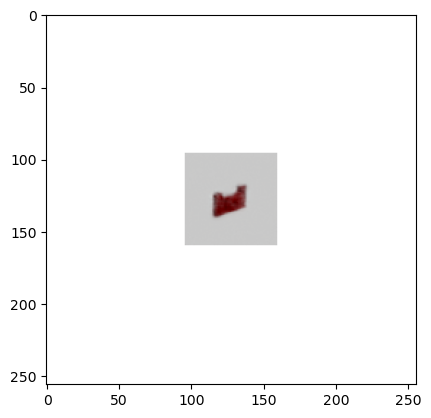

In [100]:
import matplotlib.pyplot as plt
plt.imshow(src_images_temp[1])

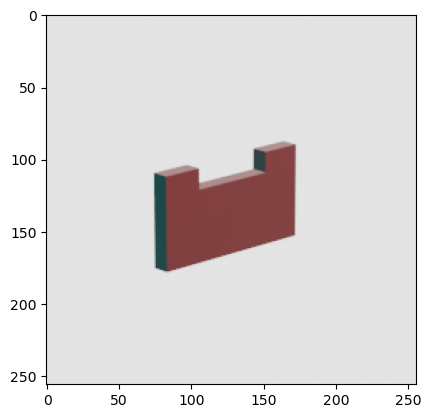

In [101]:
import matplotlib.pyplot as plt
plt.imshow(tar_images_temp[1])

In [102]:
import numpy as np
def define_discriminator(image_shape):
    init = RandomNormal(stddev=0.02)
    in_src_image = Input(shape=image_shape)
 # target image input
    in_target_image = Input(shape=image_shape)
 # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
 # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
 # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
 # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
 # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
 # define model
    model = Model([in_src_image, in_target_image], patch_out)
 # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [103]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
 # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
 # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
 # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
 # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
 # add batch normalization
    g = BatchNormalization()(g, training=True)
 # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
 # merge with skip connection
    g = Concatenate()([g, skip_in])
 # relu activation
    g = Activation('relu')(g)
    return g

In [104]:
def define_generator(image_shape=(256,256,3)):
    init = RandomNormal(stddev=0.02)
 # image input
    in_image = Input(shape=image_shape)
 # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
 # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
 # decoder model
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
 # output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
 # define model
    model = Model(in_image, out_image)
    return model 

In [105]:
def define_gan(g_model, d_model, image_shape):
 # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
            # define the source image
            in_src = Input(shape=image_shape)
            # connect the source image to the generator input
            gen_out = g_model(in_src)
            # connect the source input and generator output to the discriminator input
            dis_out = d_model([in_src, gen_out])
            # src image as input, generated image and classification output
            model = Model(in_src, [dis_out, gen_out])
            # compile model
            opt = Adam(lr=0.0002, beta_1=0.5)
            model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

In [106]:
def load_real_samples(filename):
    data=load(filename)
    X1,X2=data['arr_0'], data['arr_1']
    X1=(X1-127.5)/127.5
    X2=(X2-127.5)/127.5
    return [X1,X2]  
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    trainA, trainB = dataset
 # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
 # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
 # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y
def generate_fake_samples(g_model, samples, patch_shape):
    X = g_model.predict(samples)
 # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y


In [107]:
from matplotlib import pyplot
def summarize_performance(step, g_model, d_model,trainA,trainB,n_samples=3):
    [X_realA, X_realB], _ = generate_real_samples([trainA,trainB], n_samples, 1)
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i])
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i])
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i])
    filename1 = 'plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    filename2 = 'gmodel.h5' 
    g_model.save(filename2)
    filename3 = 'dmodel.h5'
    d_model.save(filename3)

In [ ]:
def train(d_model, g_model, gan_model, trainA,trainB, n_epochs=15, n_batch=1):
    n_patch=d_model.output_shape[1]
    bat_per_epo=int(len(trainA)/n_batch)
    n_steps=bat_per_epo*n_epochs
    for i in range(n_steps):
        [X_realA,X_realB],y_real=generate_real_samples([trainA,trainB],n_batch,n_patch)
        X_fakeB,y_fake=generate_fake_samples(g_model,X_realA,n_patch)
        d_loss1=d_model.train_on_batch([X_realA,X_realB],y_real)
        d_loss2=d_model.train_on_batch([X_realA,X_fakeB],y_fake)
        g_loss,_,_=gan_model.train_on_batch(X_realA,[y_real,X_realB])
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1,d_loss1,d_loss2,g_loss))
        if(i+1)%(bat_per_epo*1)==0:
            summarize_performance(i,g_model,d_model, trainA,trainB)      

In [ ]:
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy()

In [ ]:
from tensorflow.keras.models import load_model
#with strategy.scope():
image_shape=(256,256,3)
    #d_model = define_discriminator(image_shape)
    #g_model = define_generator(image_shape)
d_model = load_model('../input/modelstranslation/dmodel16.h5')
g_model = load_model('../input/modelstranslation/gmodel16.h5')
gan_model = define_gan(g_model, d_model, image_shape)
train(d_model, g_model, gan_model, src_images,tar_images)

In [108]:
test_images = np.load('../input/modelstranslation/resultstest.npy')
print(test_images.shape)
tar_images_test2 = np.load('../input/rendering7/imagestest.txt.npy')
indexes_to_remove = [11, 13,18,43,45,52,75]
tar_images_test2= np.delete(tar_images_test2, indexes_to_remove, axis=0)
print(tar_images_test2.shape)

(84, 64, 64, 3)
(77, 64, 64, 3)


In [109]:
from keras.models import load_model
from numpy import vstack
model1 = load_model('../input/modelstranslation/gmodel18.h5')
model2 = load_model('../input/modelstranslation/dmodel18.h5')
test_images2=[]
for old_image in test_images:
    new_image = np.ones((256, 256, 3))
    start_x = (256 - 64) // 2
    start_y = (256 - 64) // 2
    new_image[start_y:start_y+64, start_x:start_x+64, :] = old_image
    test_images2.append(new_image)
test_images2=np.array(test_images2)
print(test_images2.shape)
test_images2 = (test_images2 * 2.0) - 1.0
indexes_to_remove = [11, 13,18,43,45,52,75]#bad data
test_images2= np.delete(test_images2, indexes_to_remove, axis=0)
gen_images = model1.predict(test_images2)
print(gen_images.shape)

/opt/conda/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


(84, 256, 256, 3)
3/3 [==============================] - 20s 6s/step
(77, 256, 256, 3)


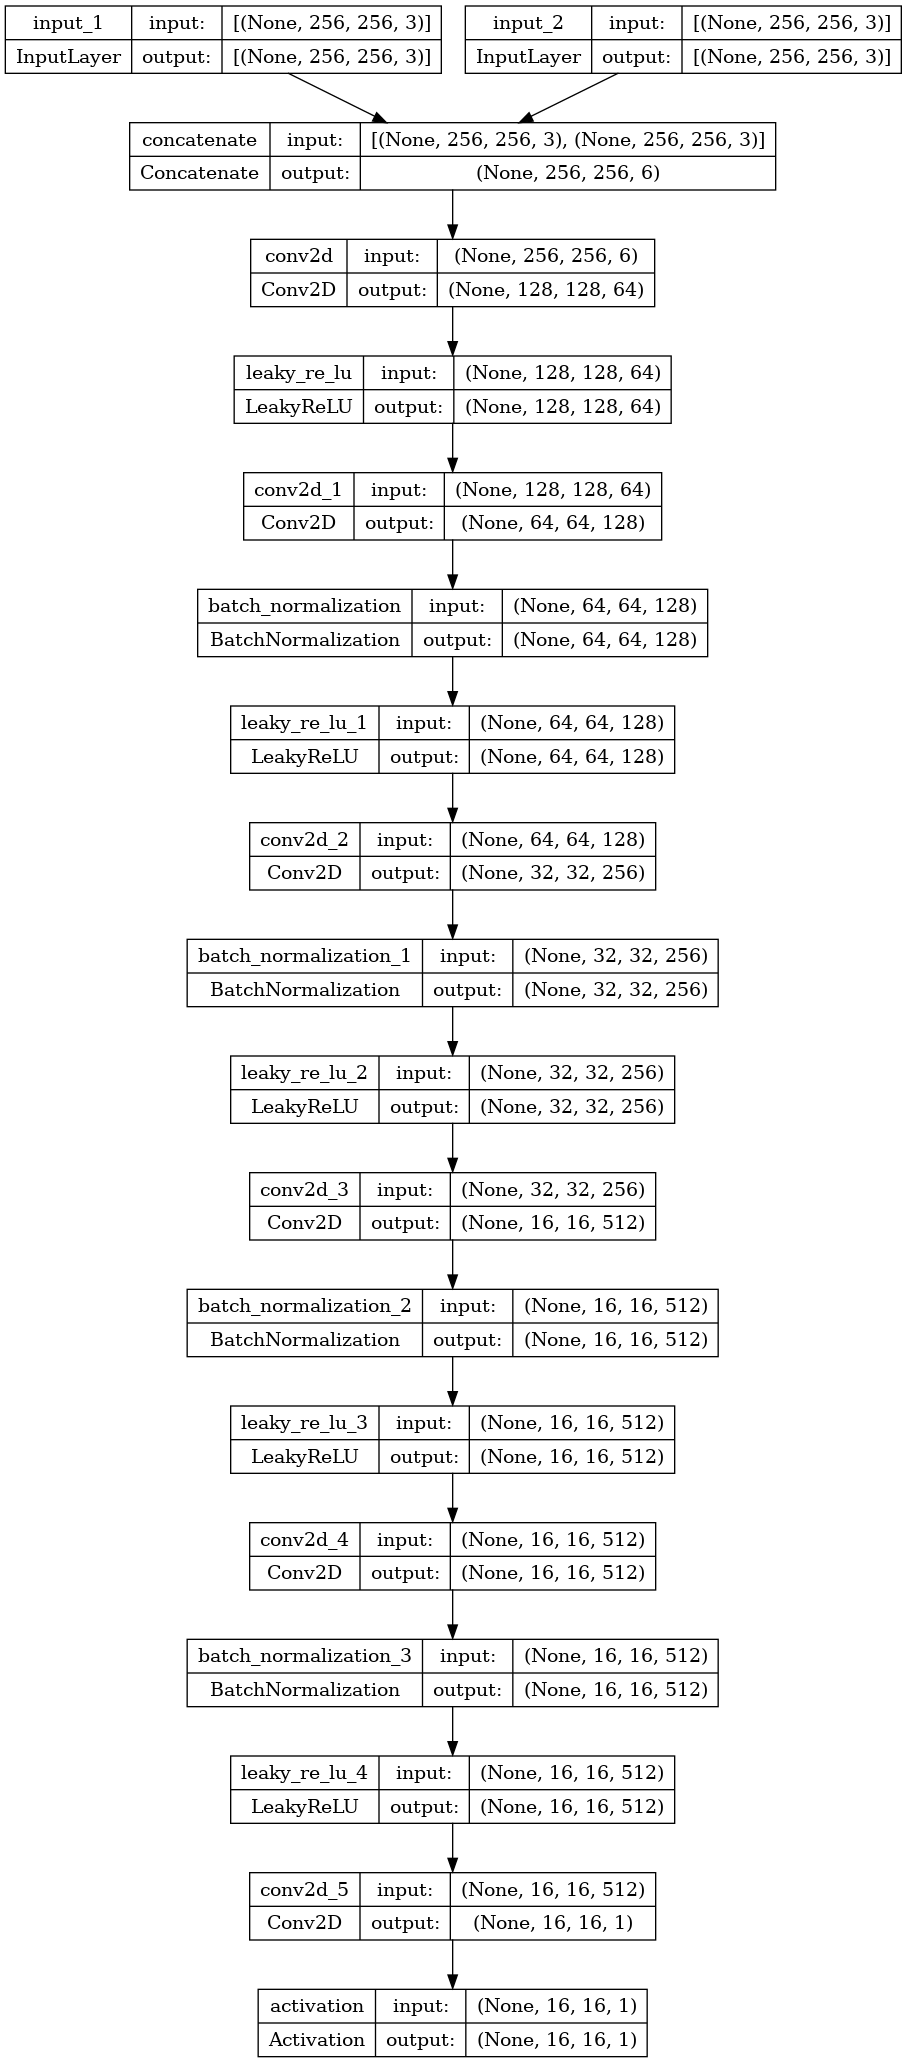

In [110]:
from tensorflow.keras.utils import plot_model
from graphviz import Source
import pydot
from graphviz import Digraph
from keras.models import load_model
plot_model(model2, to_file='model2.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [111]:
gen_images=(gen_images+1)/2.0
test_images2=(test_images2+1)/2.0

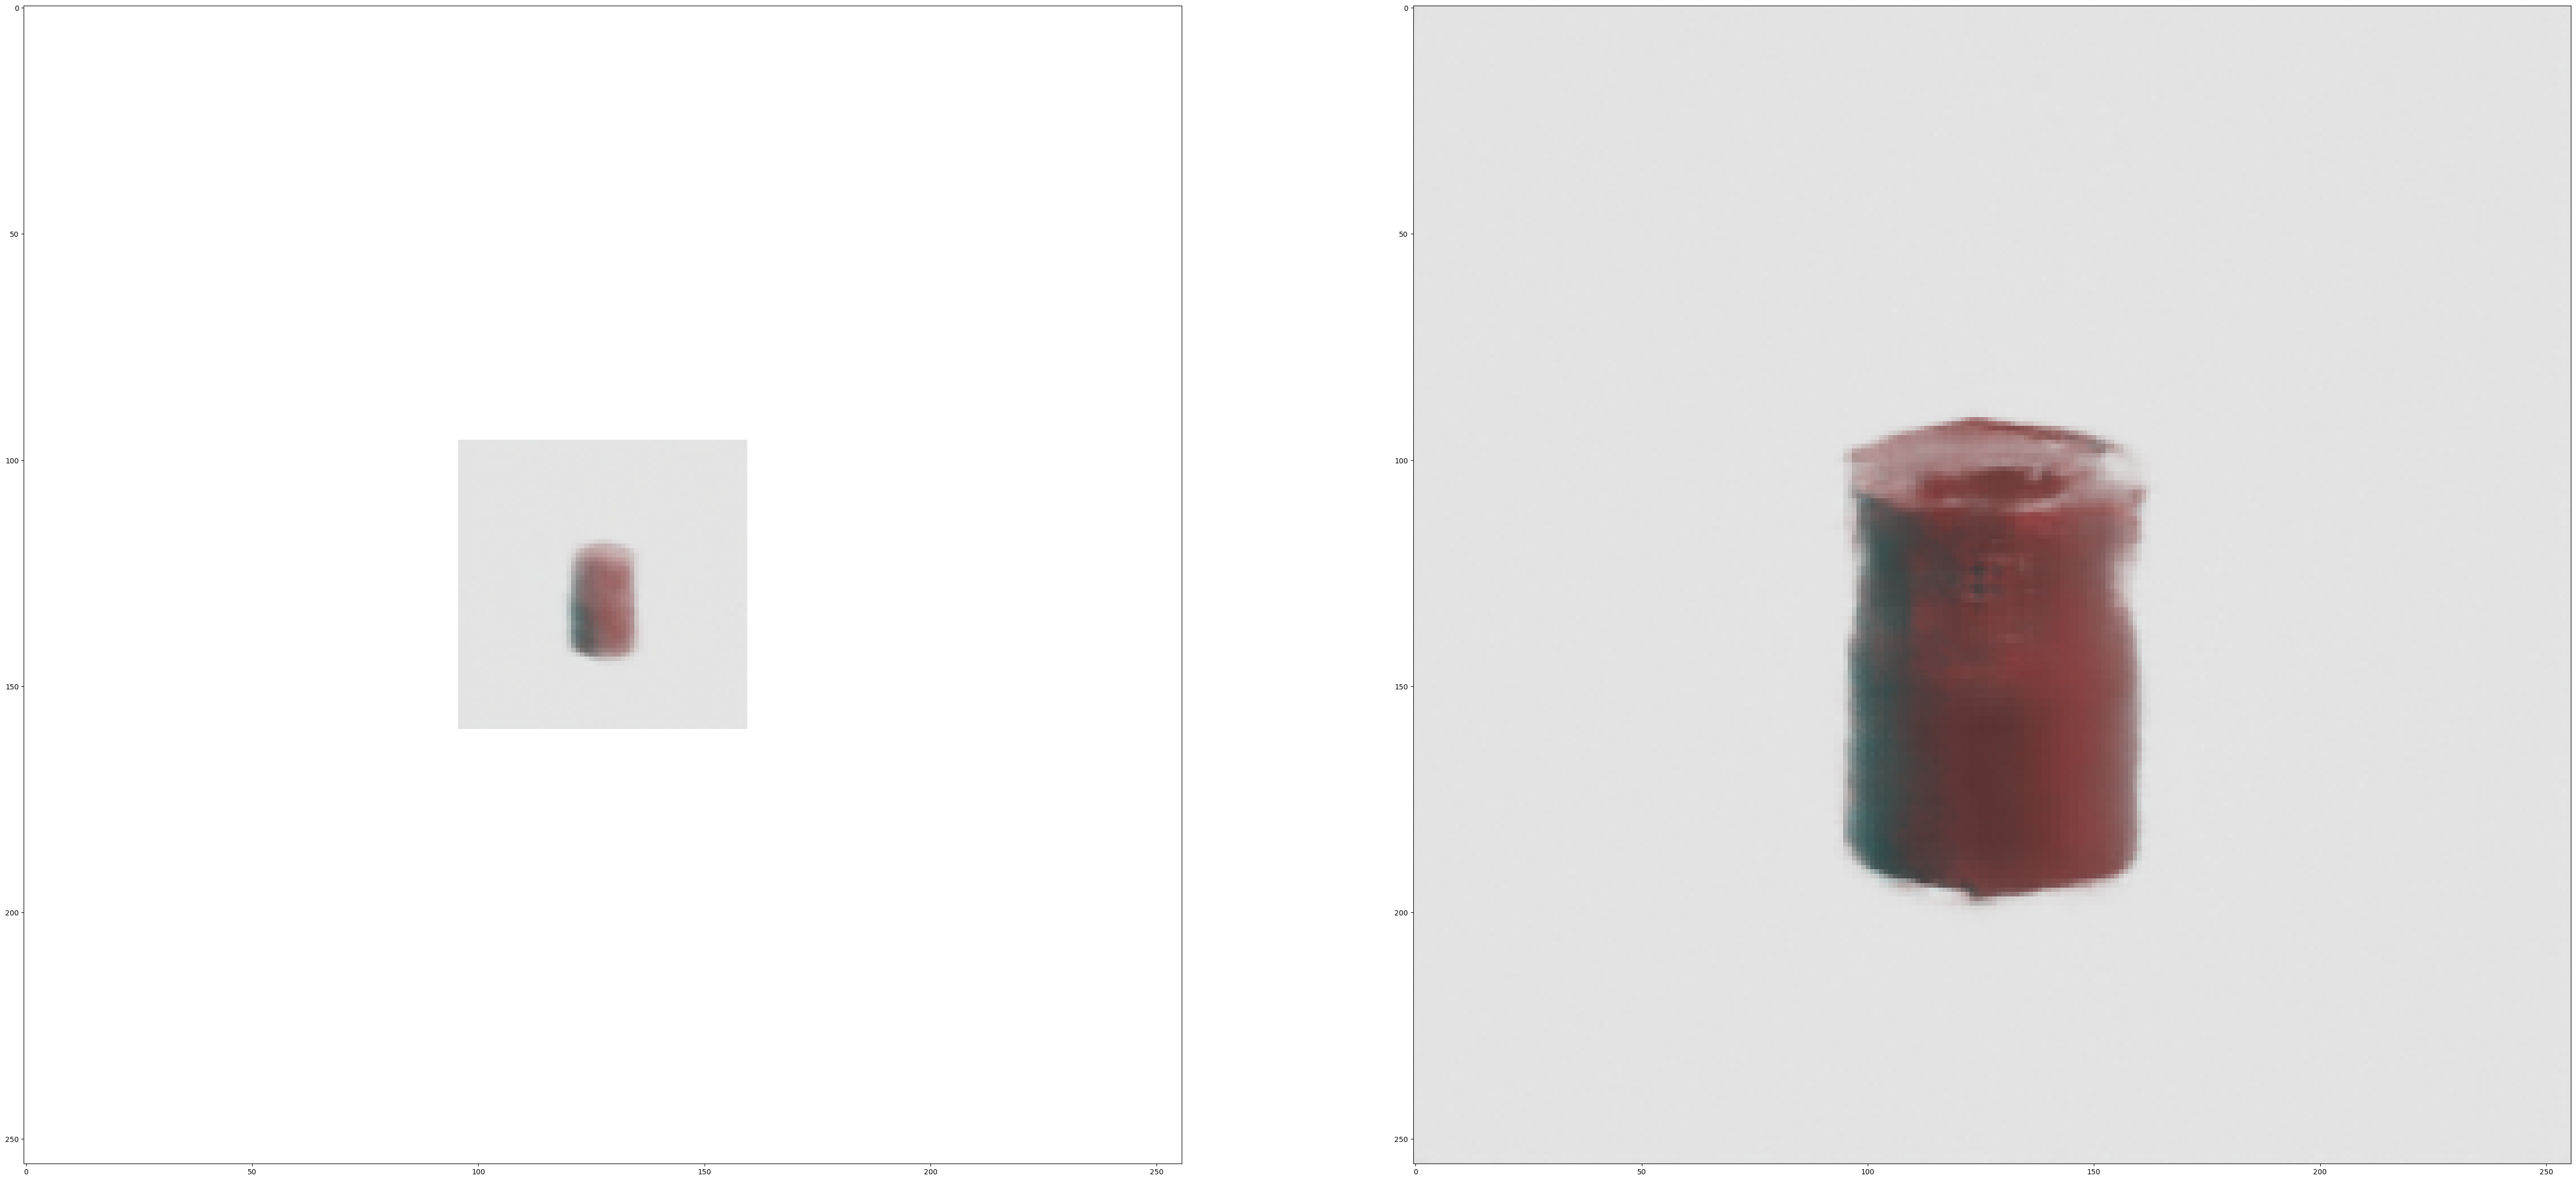

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(64, 64))
axes[0].imshow(test_images2[50])
axes[1].imshow(gen_images[50])

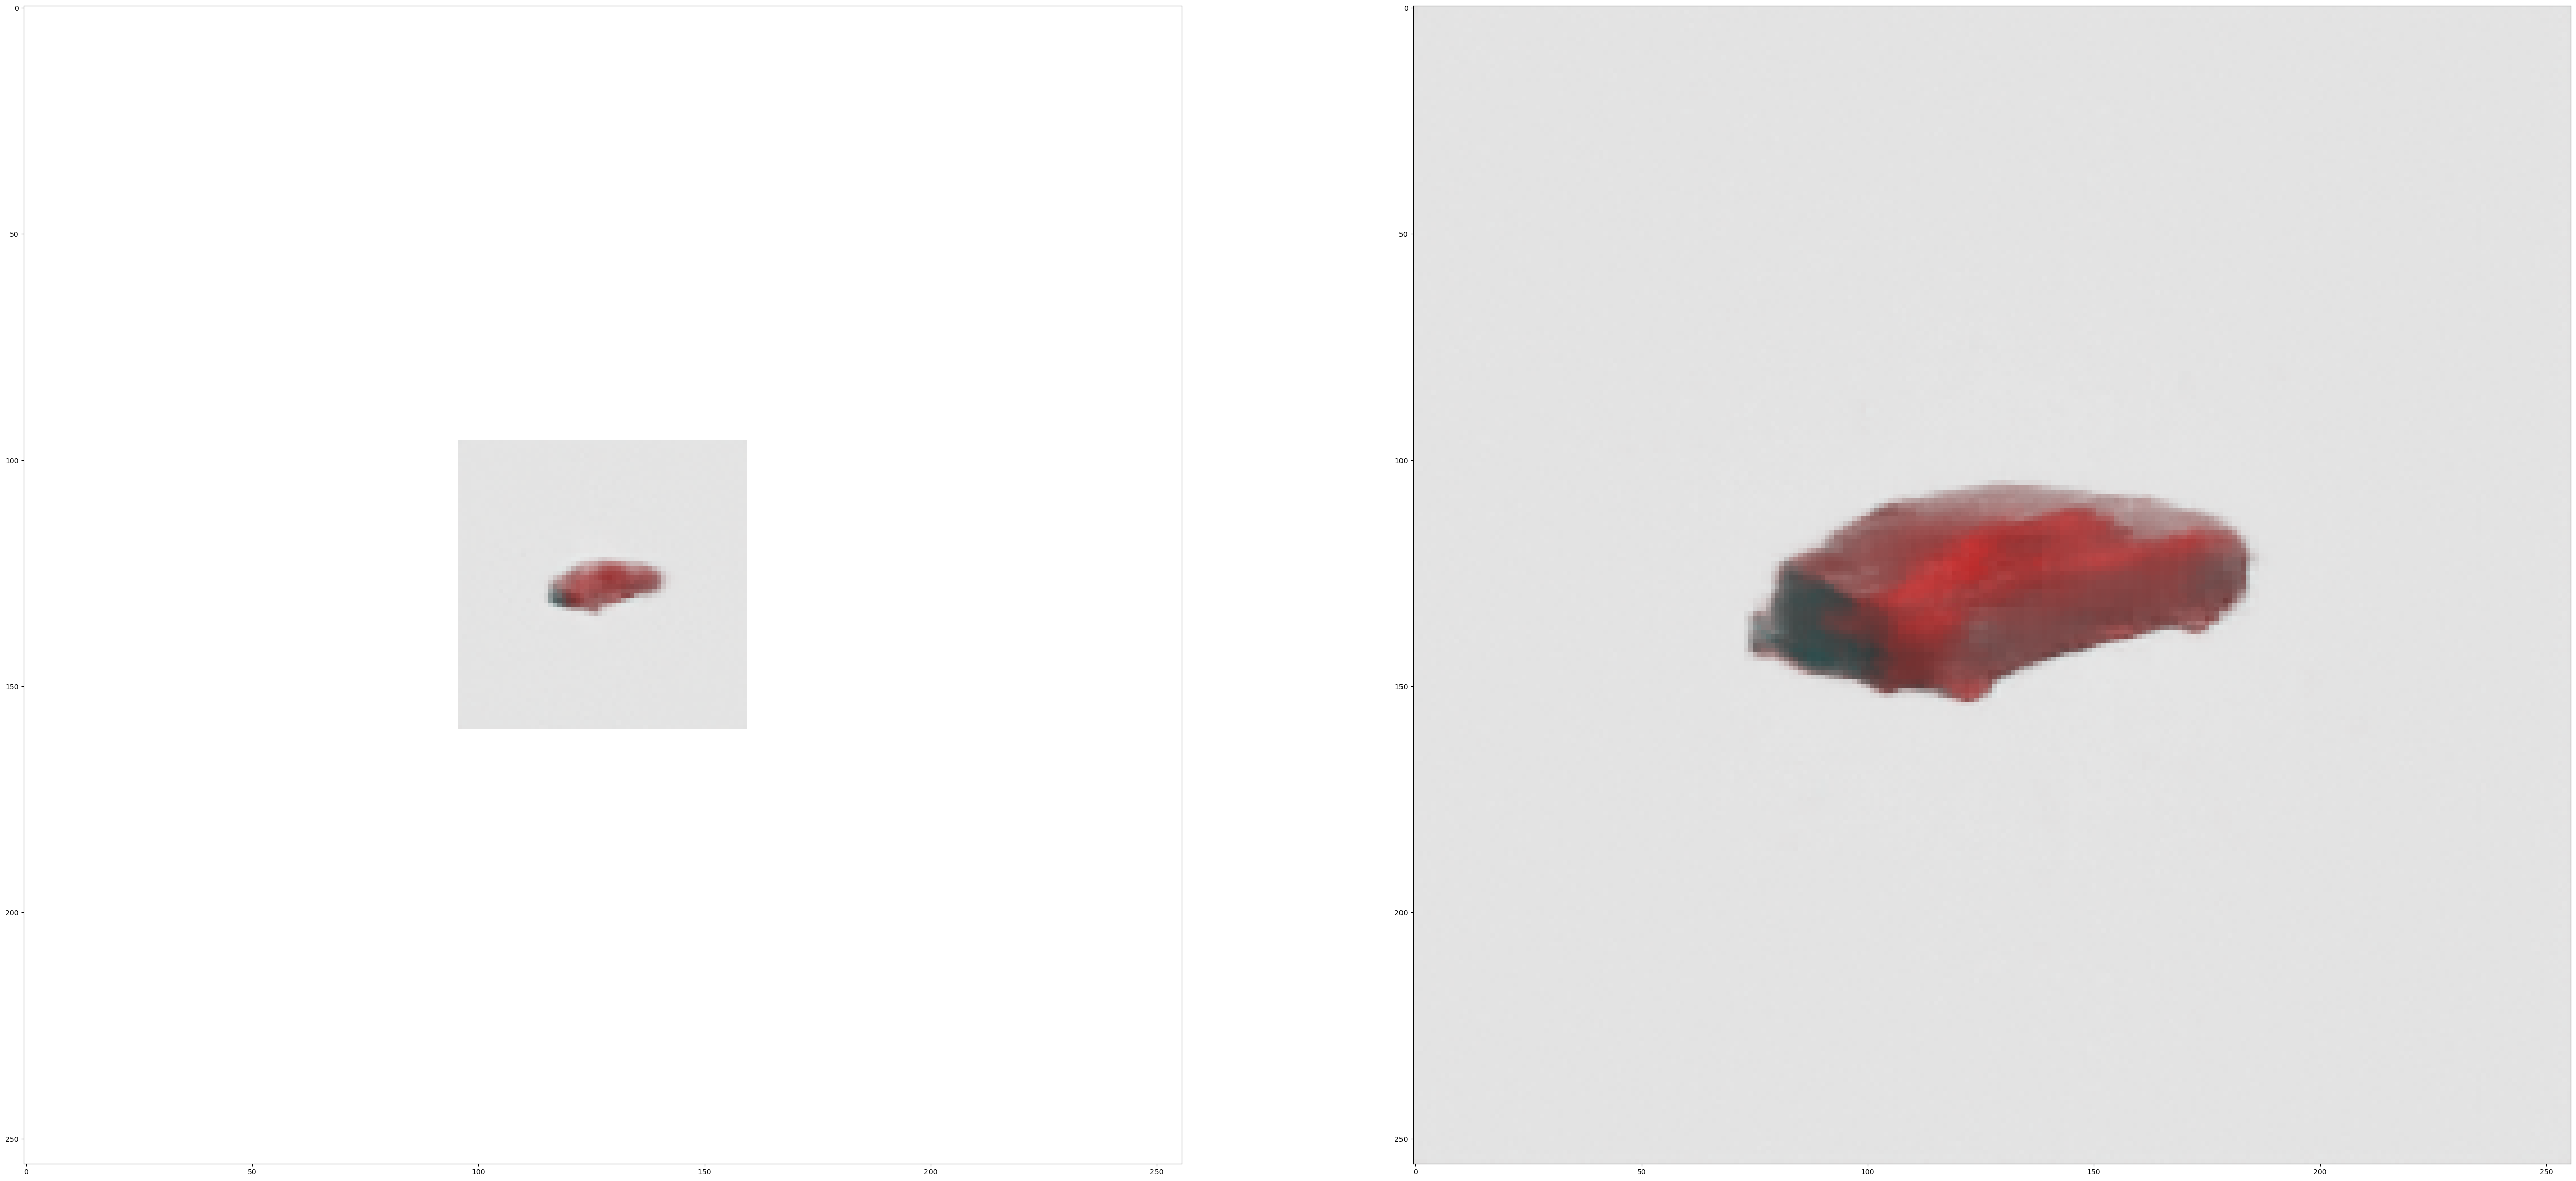

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(64, 64))
axes[0].imshow(test_images2[10])
axes[1].imshow(gen_images[10])

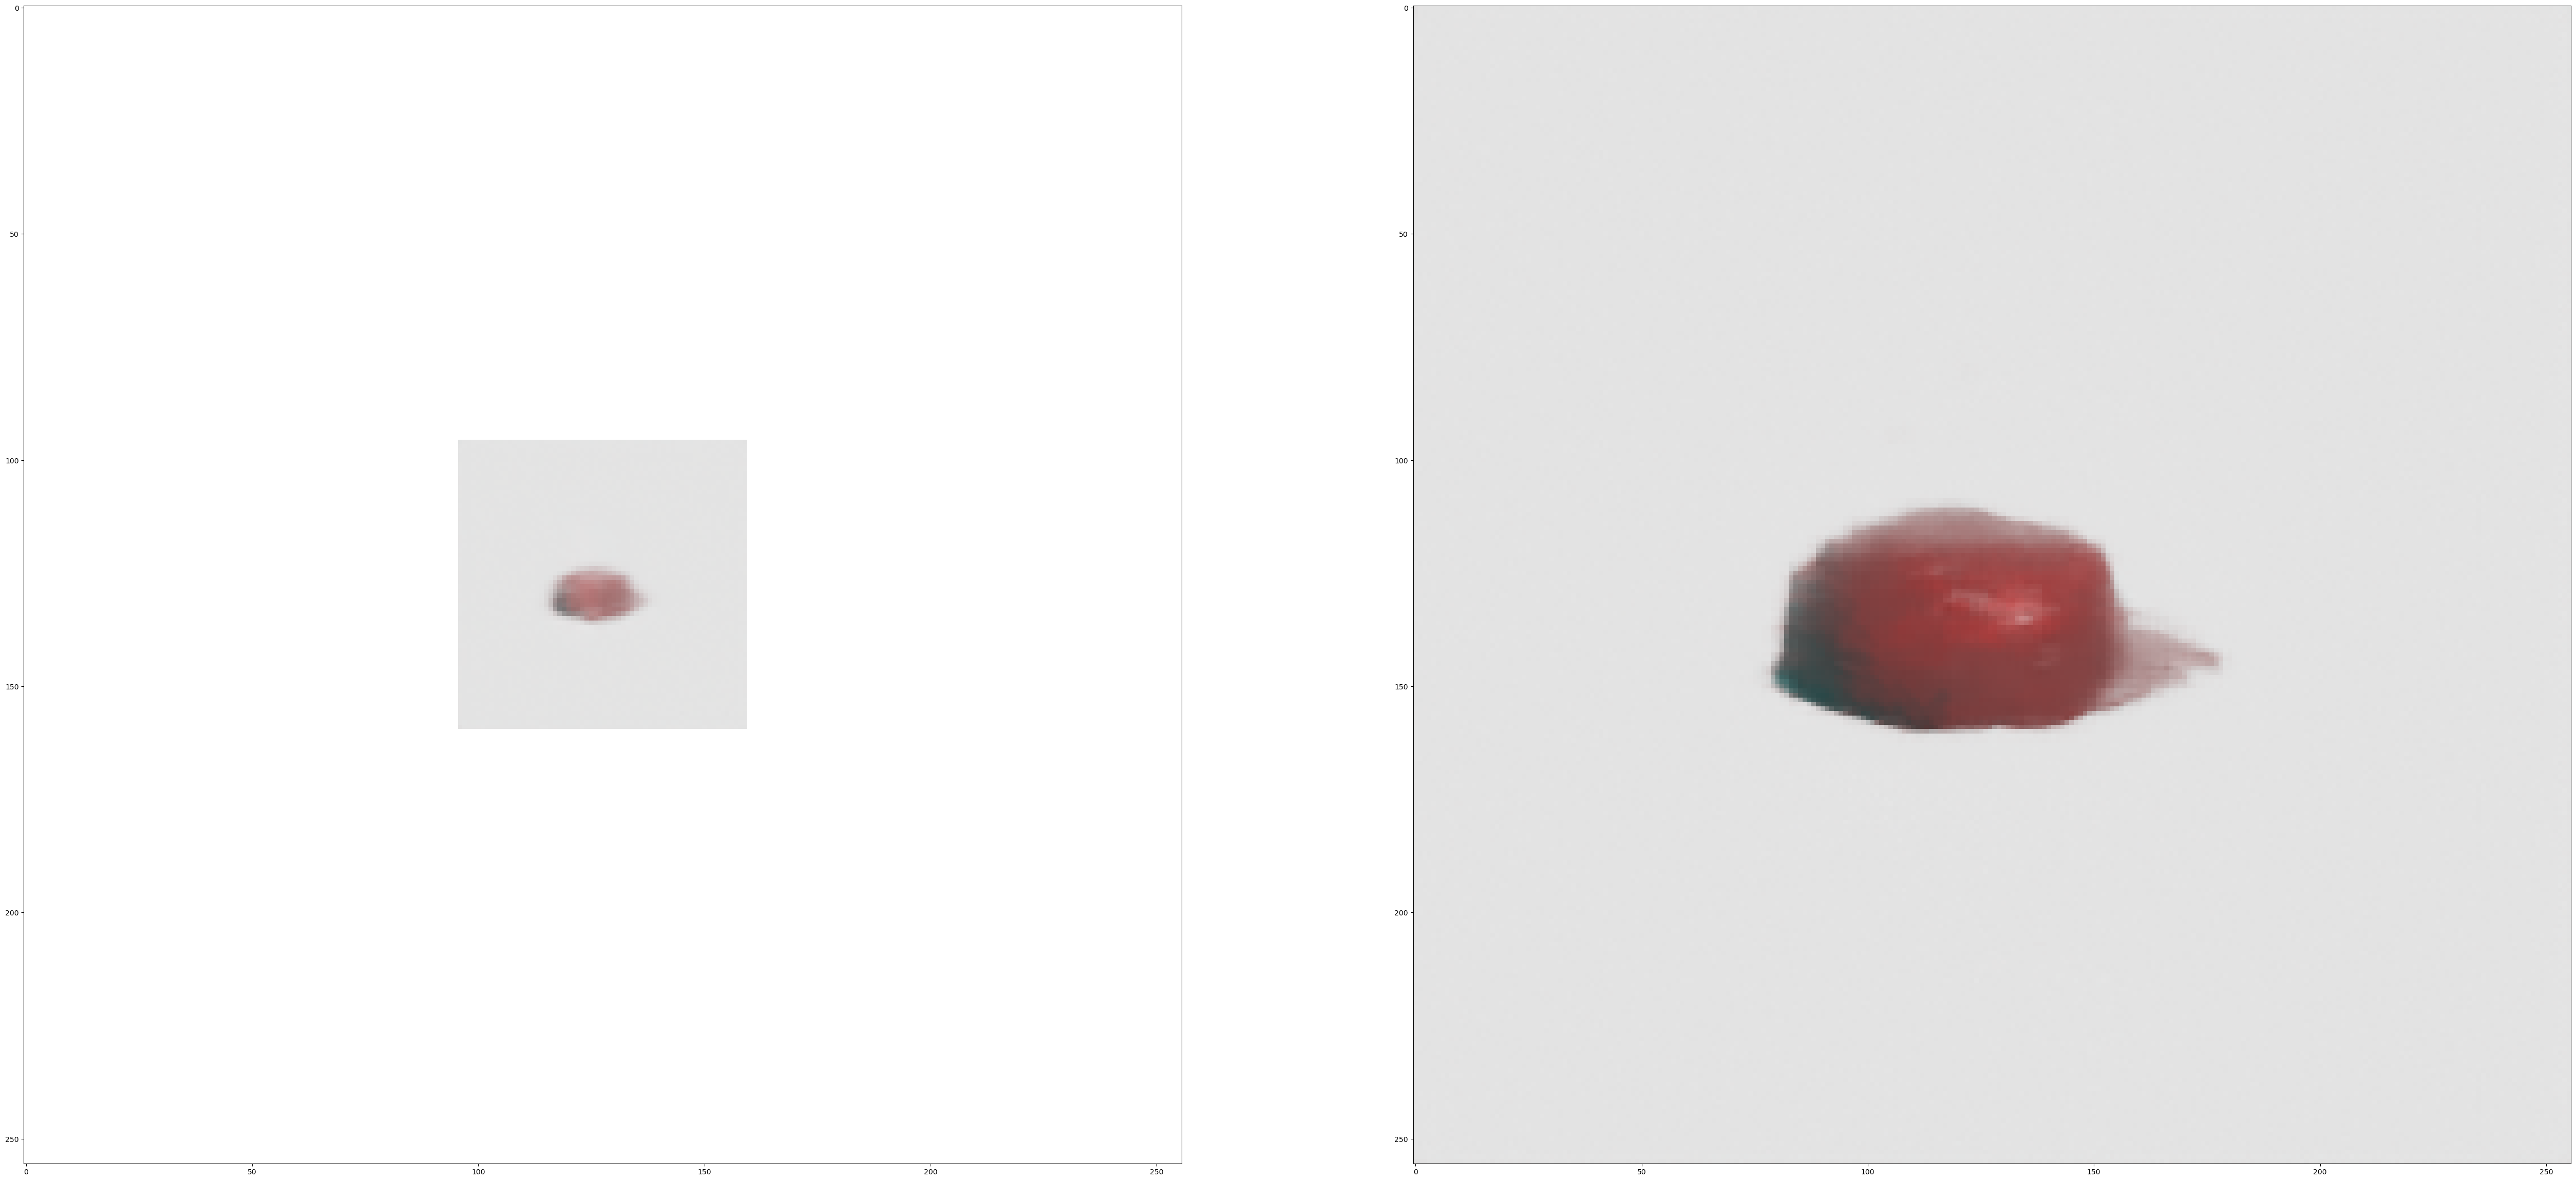

In [115]:
fig, axes = plt.subplots(1, 2, figsize=(64, 64))
axes[0].imshow(test_images2[20])
axes[1].imshow(gen_images[20])

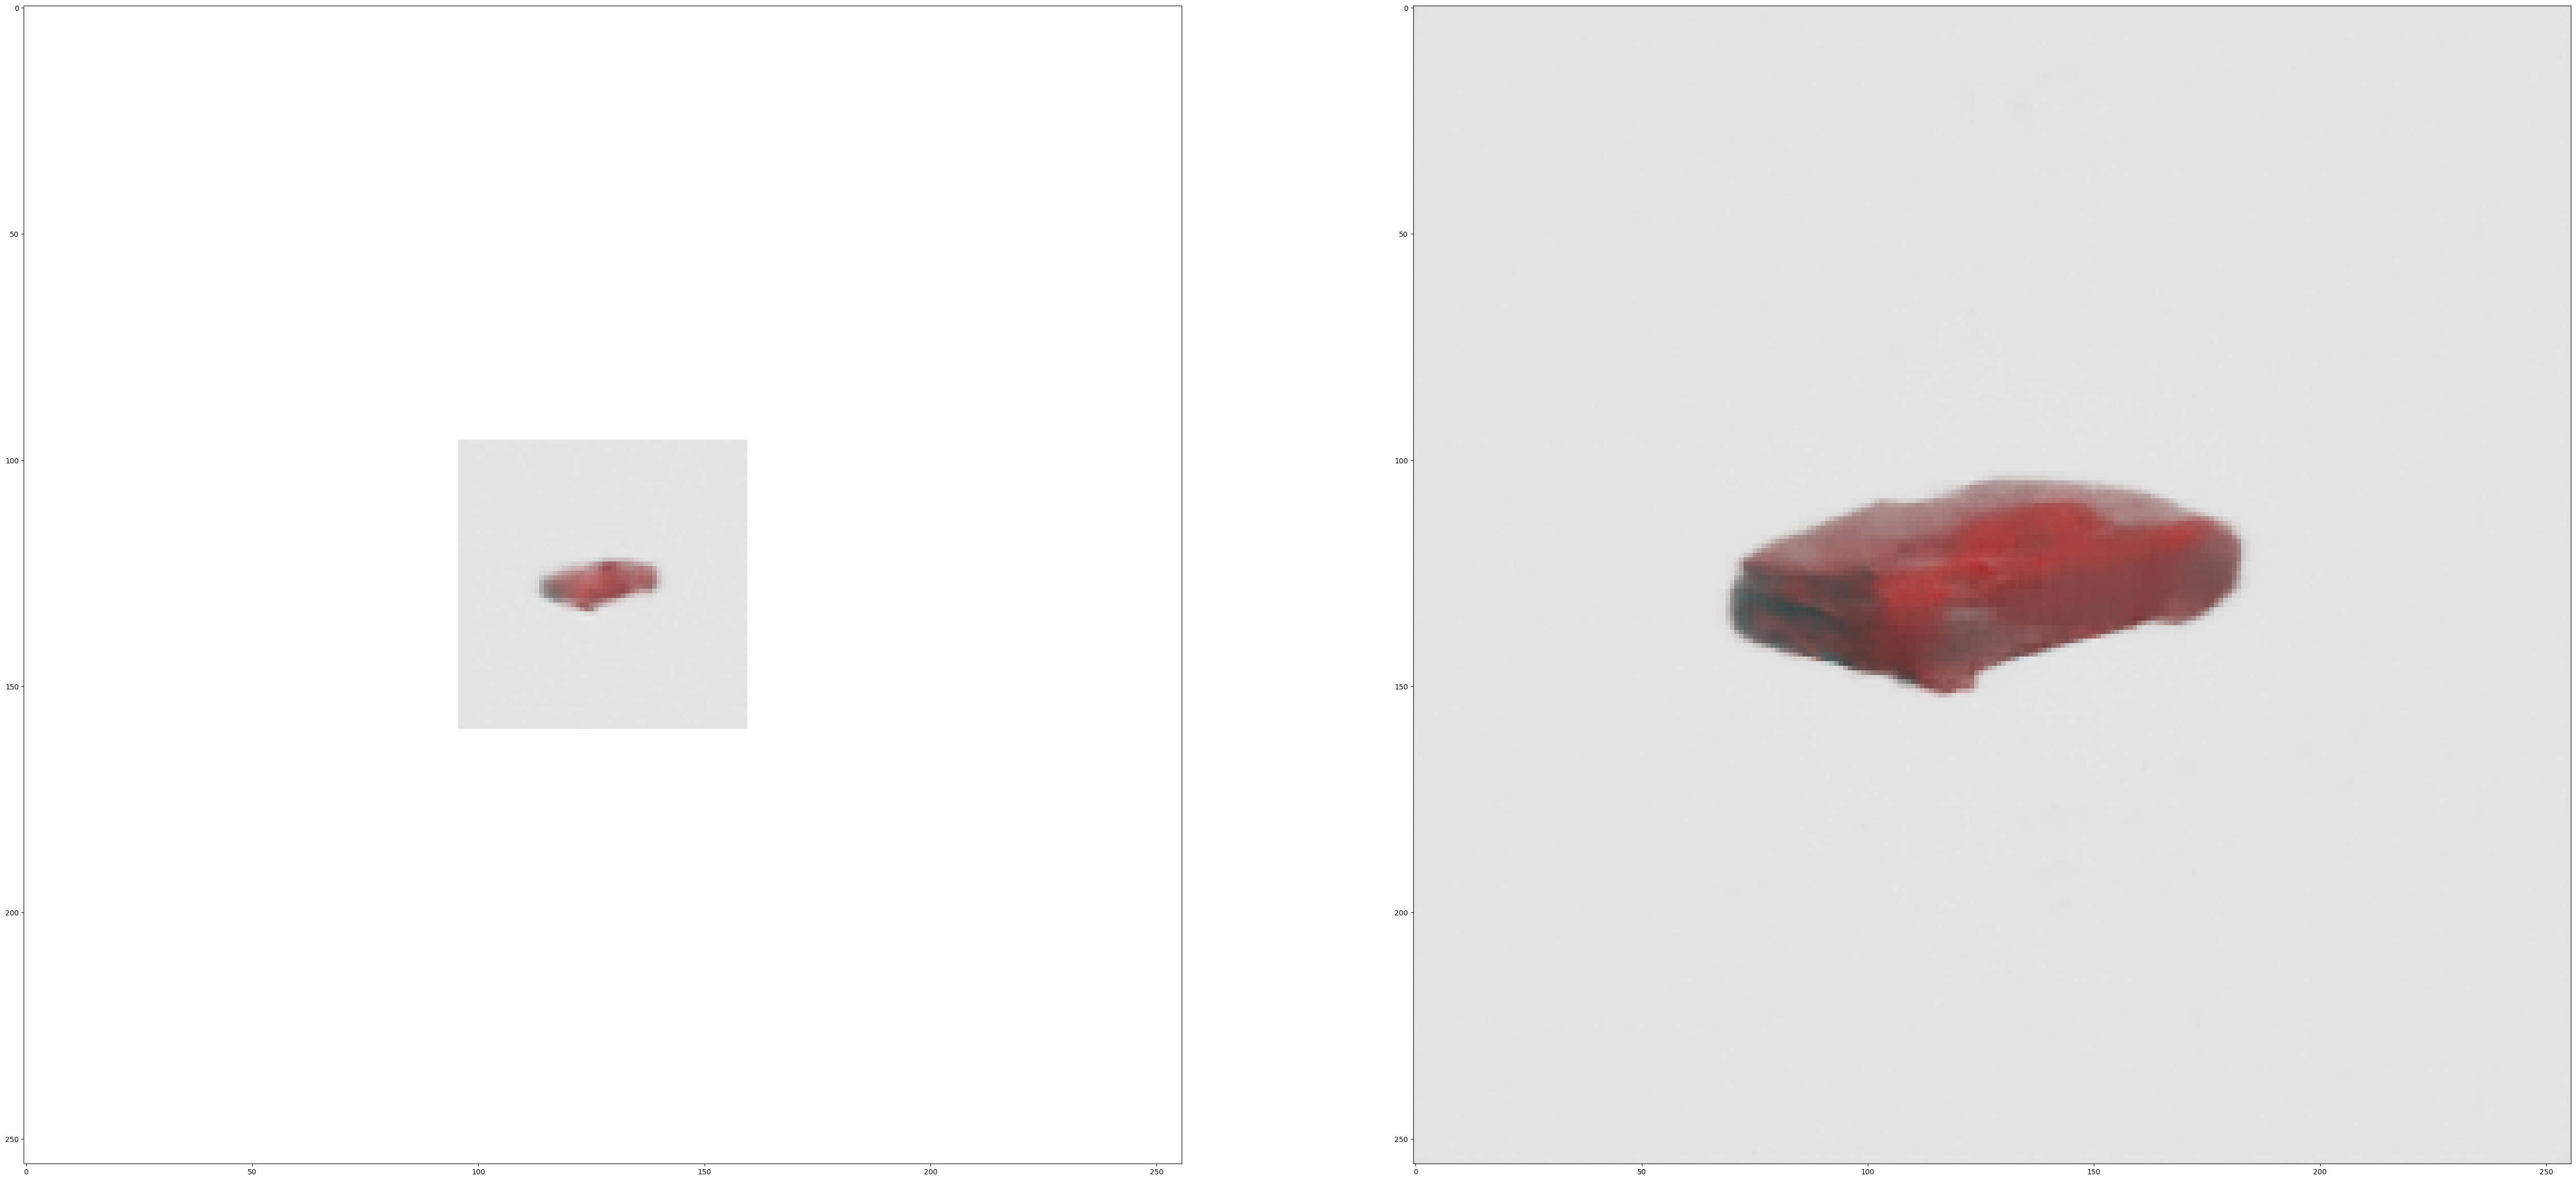

In [116]:
fig, axes = plt.subplots(1, 2, figsize=(64, 64))
axes[0].imshow(test_images2[40])
axes[1].imshow(gen_images[40])

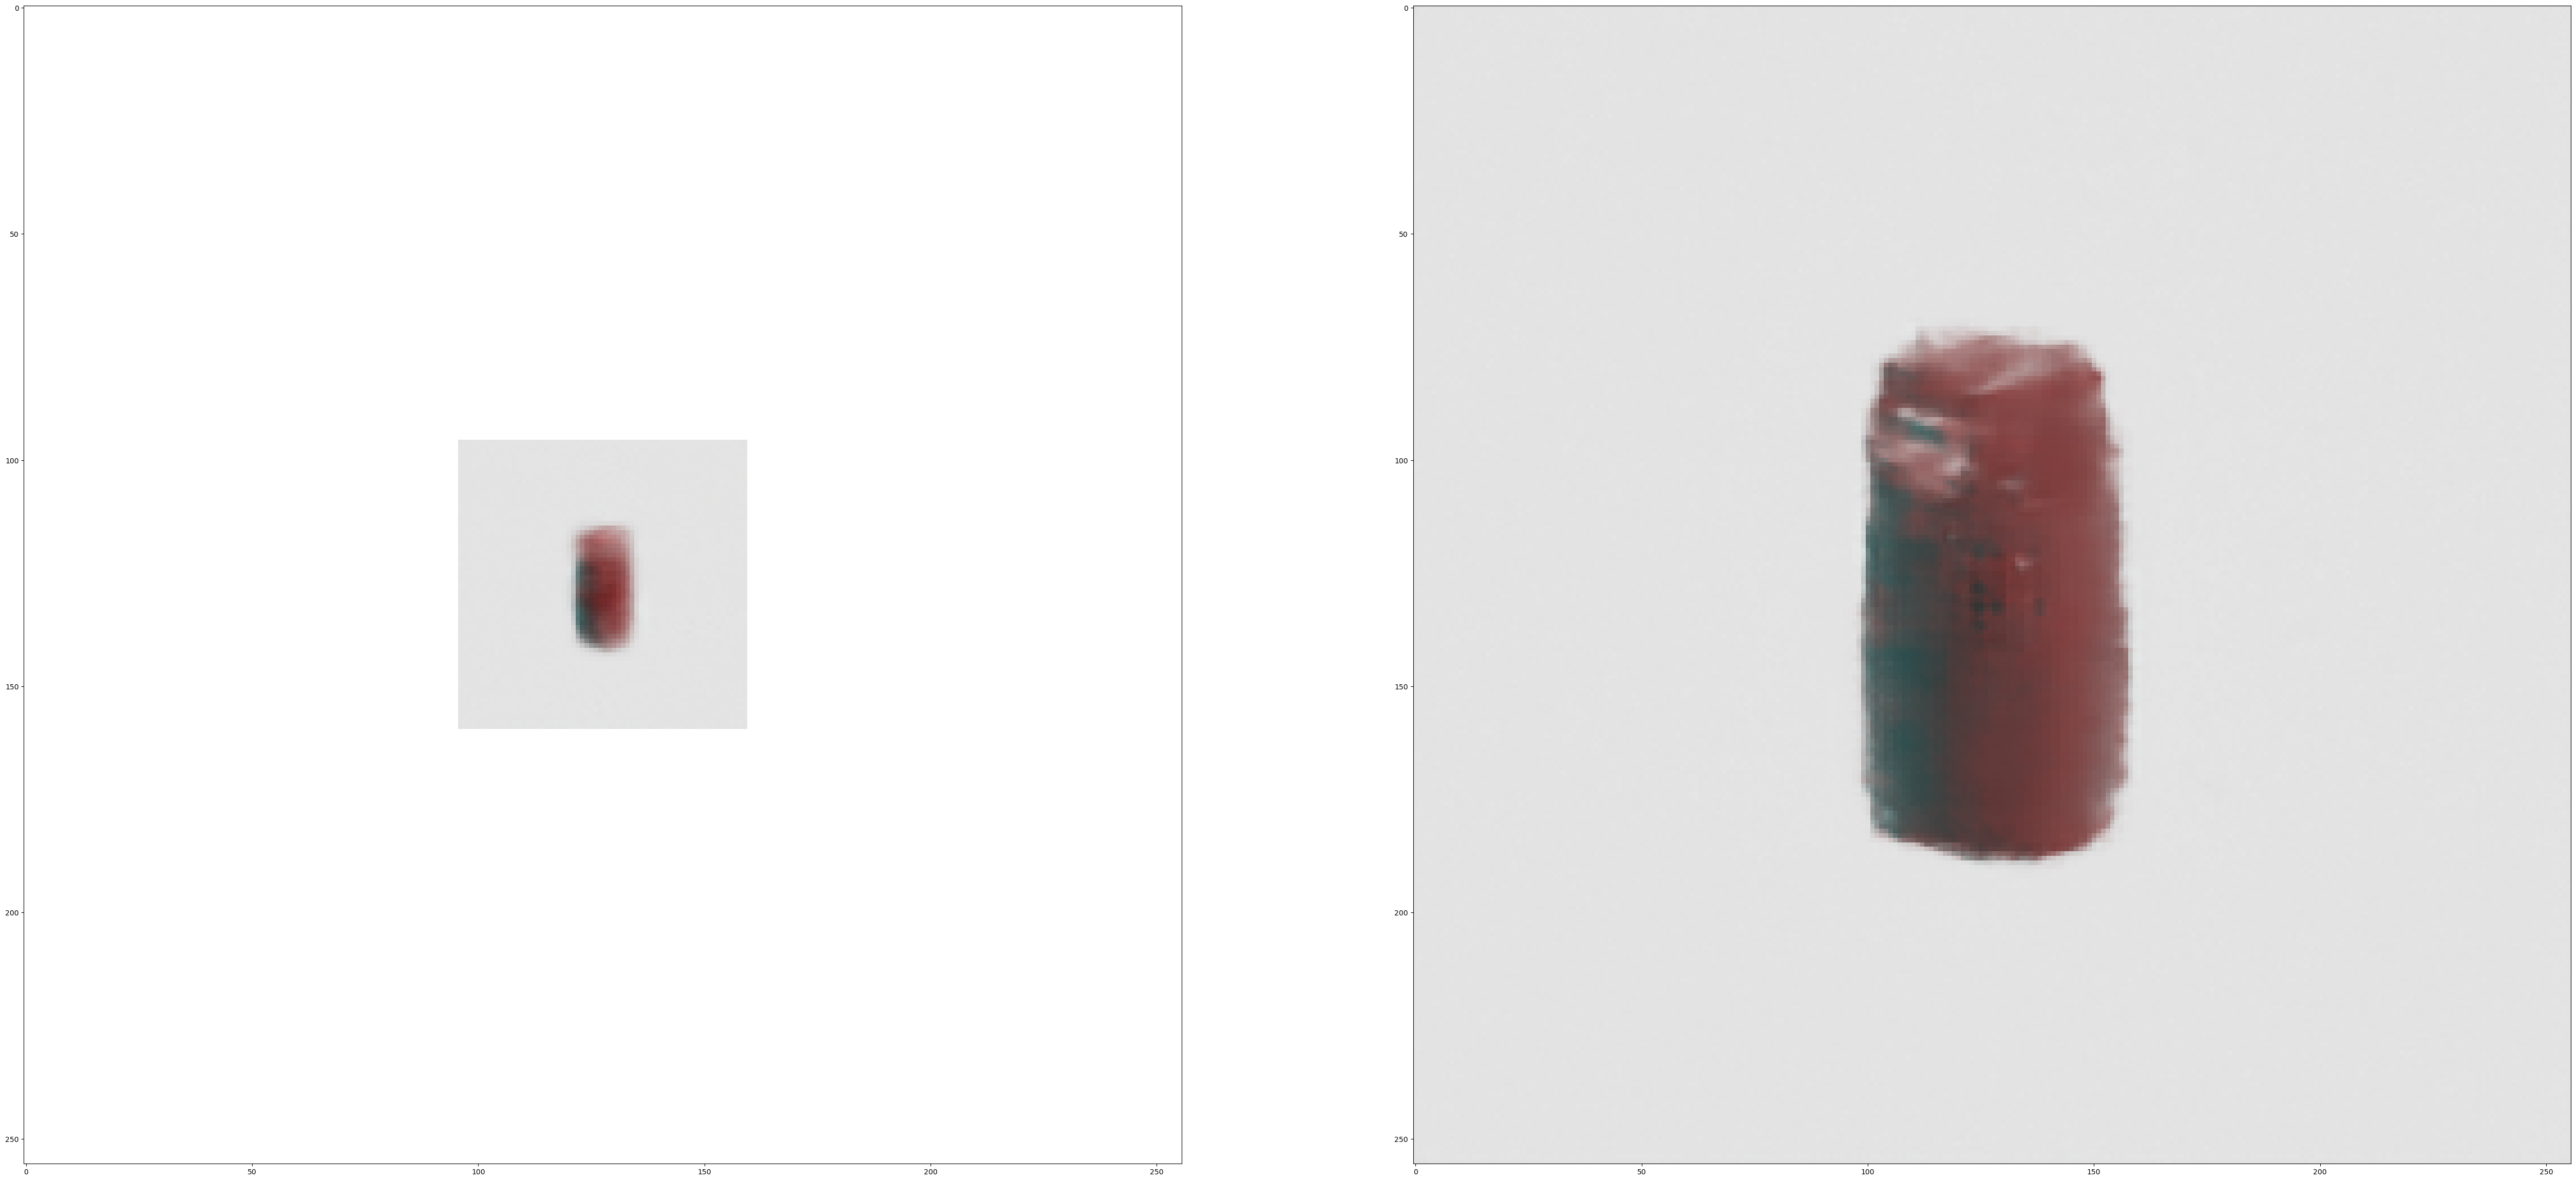

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(64, 64))
axes[0].imshow(test_images2[70])
axes[1].imshow(gen_images[70])

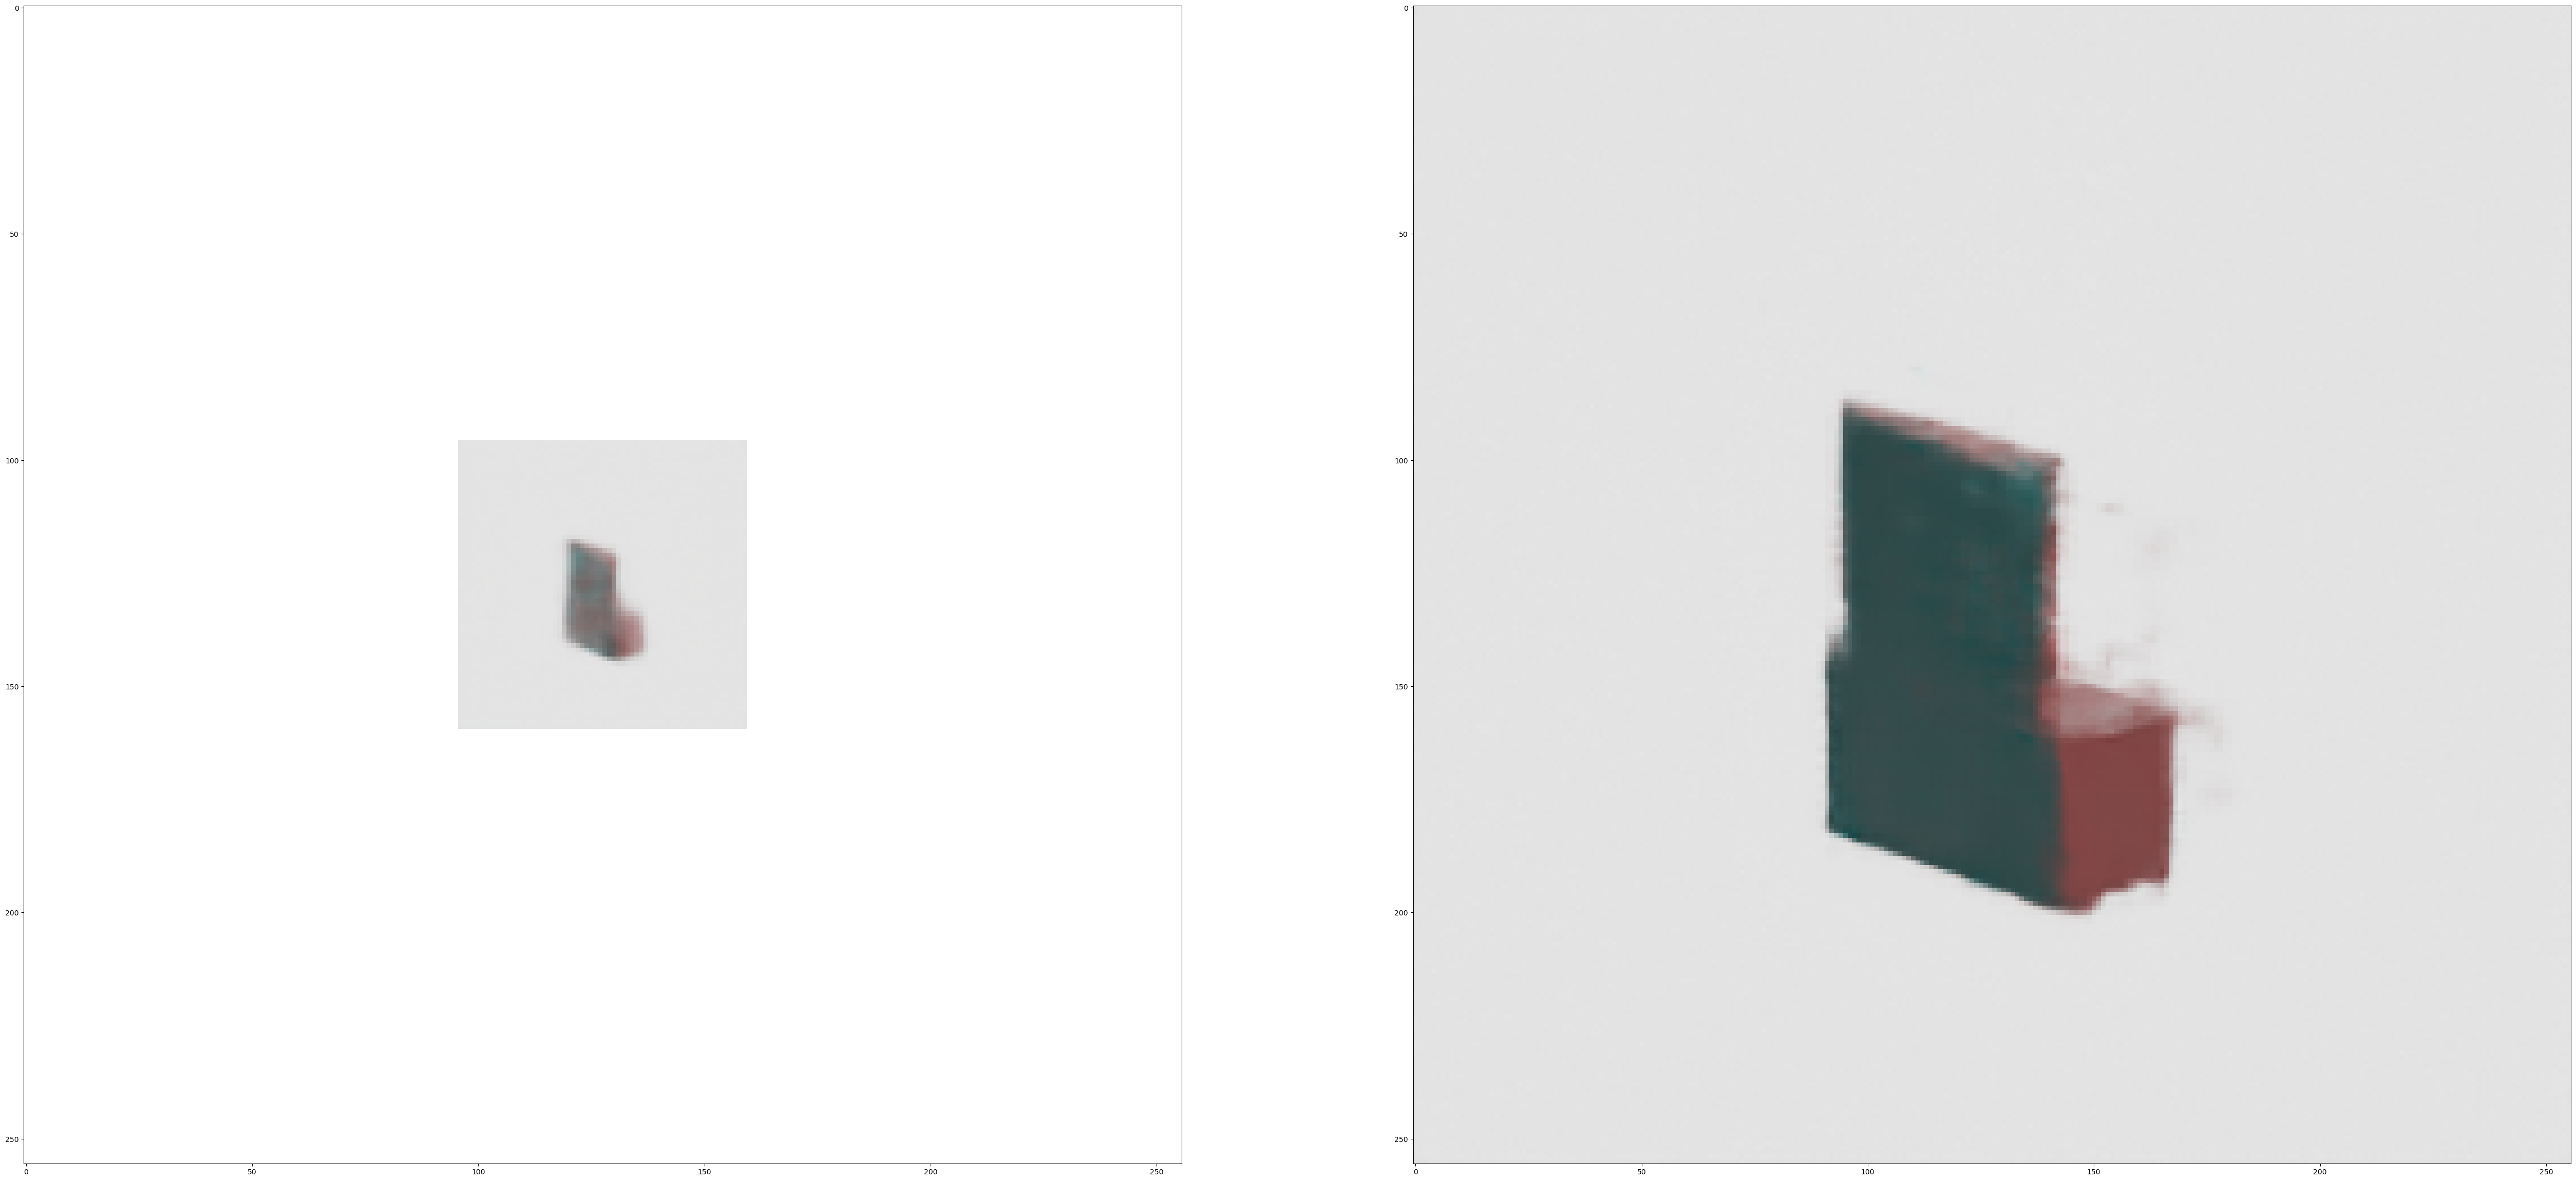

In [118]:
fig, axes = plt.subplots(1, 2, figsize=(64, 64))
axes[0].imshow(test_images2[65])
axes[1].imshow(gen_images[65])

In [119]:
from skimage.transform import resize
resized_images = np.zeros((77, 64, 64, 3), dtype=np.float32)
# Loop through each image and resize using bilinear interpolation
for i in range(77):
    resized_images[i] = resize(gen_images[i], (64, 64, 3), mode='constant', preserve_range=True)

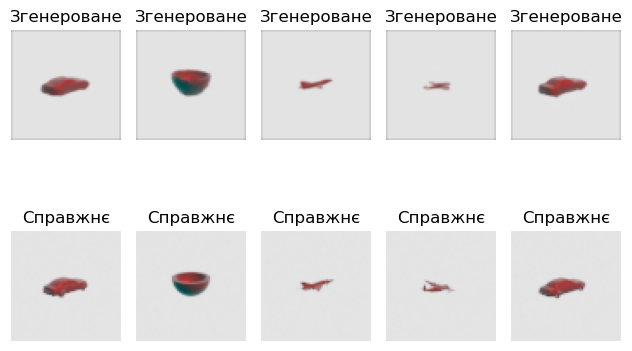

In [120]:
num_rows = 2
num_cols = 5
import matplotlib.pyplot as plt
# Loop through the images and create the grid
for i,item in enumerate([0,2,3,4,25]):
    plt.subplot(num_rows, num_cols, i+1)
    plt.axis('off')
    plt.imshow(resized_images[item])
    plt.title('Згенероване')

for i,item in enumerate([0,2,3,4,25]):
    plt.subplot(num_rows, num_cols, i+6)  # Move to the second row
    plt.axis('off')
    plt.imshow(tar_images_test2[item])
    plt.title('Справжнє')

plt.tight_layout()  # Adjust layout spacing
plt.show()

In [121]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from skimage import io, color
from skimage.metrics import structural_similarity as compare_ssim
s_values = []
first_array=resized_images
second_array=tar_images_test2
second_array = second_array.astype(np.float32) / 255.0
# Loop through the images and calculate MSE for corresponding pairs
for i in range(len(first_array)):
    s1 = compare_ssim(second_array[i,:,:,0],first_array[i,:,:,0], data_range=1)
    s2 = compare_ssim(second_array[i,:,:,1],first_array[i,:,:,1], data_range=1)
    s3 = compare_ssim(second_array[i,:,:,2],first_array[i,:,:,2], data_range=1)
    s=(s1+s2+s3)/3.0
    s_values.append(s)

# Calculate the average MSE
average_s = np.mean(s_values)
print(average_s)
intervals2 = [(0, 0.001), (0.001, 0.002), (0.002, 0.003), (0.003, 0.004), (0.004, 0.005), (0.005, 0.006),(0.006,0.1)]
intervals3 = [(0, 0.6), (0.6, 0.73), (0.73, 0.82),(0.82,0.93),(0.93,1)]
intervals = [(0, 0.55), (0.55, 0.75), (0.75, 0.85),(0.85,0.93),(0.93,1)]
interval_counts = [0] * len(intervals)

for s in s_values:
    for i, interval in enumerate(intervals):
        lower_bound, upper_bound = interval
        if lower_bound <= s < upper_bound:
            interval_counts[i] += 1

total_values = len(s_values)
percentages = [(count / total_values) * 100 for count in interval_counts]

# Print percentages for each interval
for i, interval in enumerate(intervals):
    print(f"Percentage of values in interval {interval}: {percentages[i]:.2f}%")

0.9054646020580436
Percentage of values in interval (0, 0.55): 0.00%
Percentage of values in interval (0.55, 0.75): 1.30%
Percentage of values in interval (0.75, 0.85): 9.09%
Percentage of values in interval (0.85, 0.93): 49.35%
Percentage of values in interval (0.93, 1): 40.26%
